# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [ ]:
# Load the libraries as required.
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))

fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [7]:
# Set features and target
X = fires_dt.drop(columns='area')
Y = fires_dt['area']

print('Features shape:', X.shape)
print('Target shape:', Y.shape)

Features shape: (517, 12)
Target shape: (517,)


In [10]:
# Split the train test sets (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Train sets:', X_train.shape, Y_train.shape)
print('Test Sets:',  X_test.shape, Y_test.shape)

Train sets: (413, 12) (413,)
Test Sets: (104, 12) (104,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [11]:
# List of numerical columns
numerical_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# List of categorical columns
categorical_cols = ['month', 'day']

In [13]:
# Numerical pipeline
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into ColumnTransformer
preproc1 = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

preproc1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [25]:
# Optional - Observe the skewness
num_skew = X_train[numerical_cols].skew().sort_values(ascending=False)

num_skew

rain       19.112564
rh          0.850107
isi         0.587755
dmc         0.582128
wind        0.567032
coord_y     0.487873
coord_x     0.067740
temp       -0.272311
dc         -1.097032
ffmc       -6.473877
dtype: float64

In [65]:
# Based on observed skewness
# Positive Skew (Right Skew): rain, dmc, isi
# Negative Skew (Left Skew): dc, ffmc
# Approximately Symmetrical or Minimal Skew: rh, wind, coord_x, coord_y, temp

# THIS VERSION FAILED IN THE get_feature_names_out STEP
# Functions for log and reciprocal transformation
# def log_transform(X):
#     return np.log1p(X)

# def log_transform_neg(X):
#     return np.log1p(X.max() - X)

# CUSTOM TRANSFORMERS SO WE CAN GET get_feature_names_out
class LogTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(func=np.log1p, inverse_func=np.expm1, validate=False)
    
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self)
        if input_features is None:
            return self.feature_names_in_
        return [f"log1p({feat})" for feat in input_features]

class NegLogTransformer(FunctionTransformer):
    def __init__(self, X_max):
        self.X_max = X_max
        super().__init__(func=lambda X: np.log1p(self.X_max - X), validate=False)
    
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if hasattr(X, 'columns') else None
        return self
    
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self)
        if input_features is None:
            return self.feature_names_in_
        return [f"log1p({self.X_max}-{feat})" for feat in input_features]

# Define which transformations to apply to each skewed feature
log_columns = ['rain', 'dmc', 'isi']  # Positive skew; log is suitable
neg_log_columns = ['dc', 'ffmc']  # High negative skew; log Transformation of Reflected Data
standard_columns = ['rh', 'wind', 'coord_x', 'coord_y', 'temp']  # Low or minimal skew

# Pipelines for different types of transformations
# log_pipeline = Pipeline([
#     ('log', FunctionTransformer(log_transform, validate=False)),
#     ('scaler', StandardScaler())
# ])

# neg_log_pipeline = Pipeline([
#     ('log_neg', FunctionTransformer(log_transform_neg, validate=False)),
#     ('scaler', StandardScaler())
# ])


# Use the custom transformers
log_pipeline = Pipeline([
    ('log', LogTransformer()),
    ('scaler', StandardScaler())
])

neg_log_pipeline = Pipeline([
    ('neg_log', NegLogTransformer(X[neg_log_columns].max())),
    ('scaler', StandardScaler())
])

standard_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine pipelines
preproc2 = ColumnTransformer([
    ('log', log_pipeline, log_columns),                   # Positive skew
    ('neg_log', neg_log_pipeline, neg_log_columns),       # Negative skew
    ('standard', standard_pipeline, standard_columns),    # Minimal skew
    ('cat', categorical_pipeline, categorical_cols)
])

preproc2

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('log', LogTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['rain', 'dmc', 'isi']),
                                ('neg_log',
                                 Pipeline(steps=[('neg_log',
                                                  NegLogTransformer(X_max=dc      860.6
ffmc     96.2
dtype: float64)),
                                                 ('scaler', StandardScaler())]),
                                 ['dc', 'ffmc']),
                                ('standard',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['rh', 'wind', 'coord_x', 'coord_y', 'temp']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

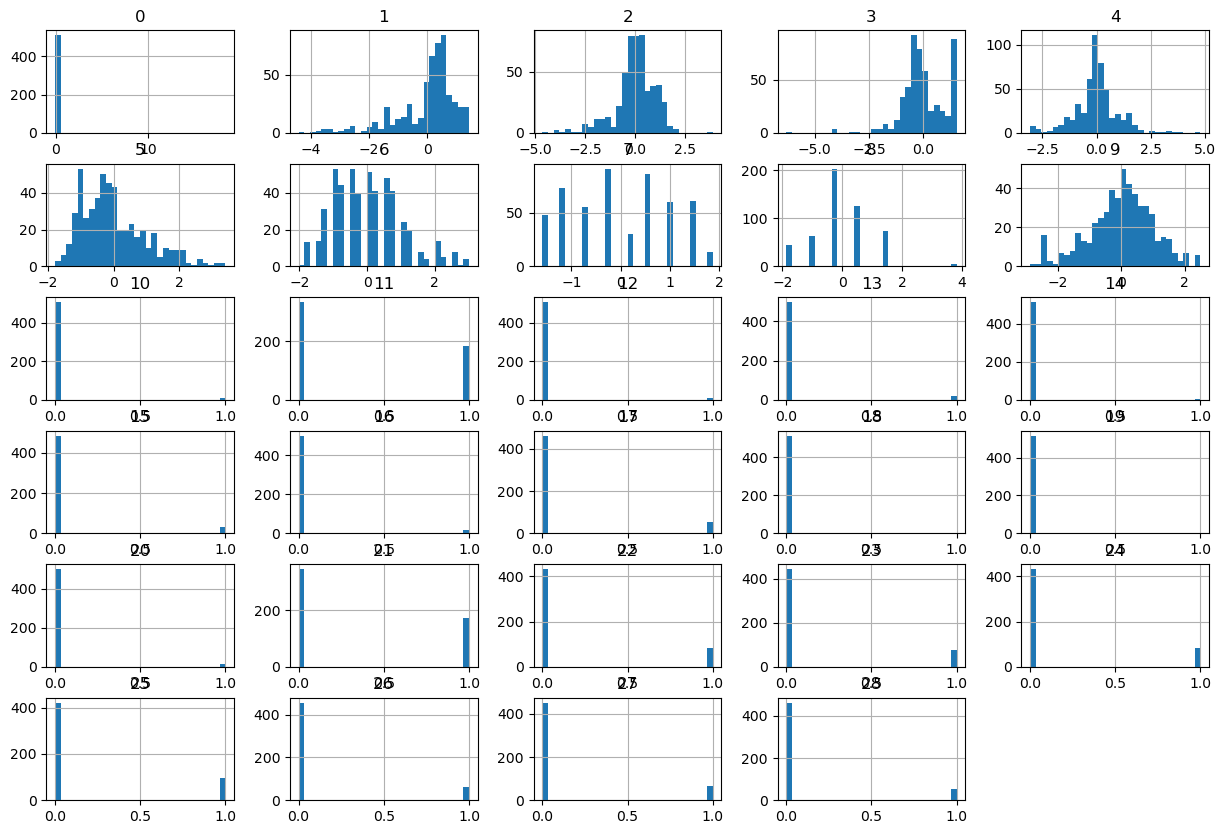

In [66]:
# Optional - check the skewness after preproc2

import matplotlib.pyplot as plt

# Example: Check skewness after transformation
transformed_data = preproc2.fit_transform(X)
transformed_df = pd.DataFrame(transformed_data)

# Plot histograms for transformed variables
transformed_df.hist(bins=30, figsize=(15, 10))
plt.show()

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [67]:
# Pipeline A = preproc1 + Ridge regressor (baseline)
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [68]:
# Pipeline B = preproc2 + Ridge regressor (baseline)
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('log',
                                                                   LogTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rain', 'dmc', 'isi']),
                                                 ('neg_log',
                                                  Pipeline(steps=[('neg_log',
                                                                   NegLogTransformer(X_max=dc      860.6
ffmc     96.2
dtype: float64)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dc', 'ffmc']),
                                                 ('standard',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rh', 'wind', 'coord_x',
                                                   'coord_y', 'temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [69]:
# Pipeline C = preproc1 + RandomForestRegressor (advanced model)
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [70]:
# Pipeline D = preproc2 + RandomForestRegressor (advanced model)
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_d
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('log',
                                                                   LogTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rain', 'dmc', 'isi']),
                                                 ('neg_log',
                                                  Pipeline(steps=[('neg_log',
                                                                   NegLogTransformer(X_max=dc      860.6
ffmc     96.2
dtype: float64)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dc', 'ffmc']),
                                                 ('standard',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rh', 'wind', 'coord_x',
                                                   'coord_y', 'temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [71]:
# For Ridge Regression (Pipelines A and B):
param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
    'regressor__fit_intercept': [True, False],
}

In [72]:
# For RandomForestRegressor (Pipelines C and D):
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 5, 10, 20]
}

In [73]:
# Perform Grid Search for each pipline
# Score = Neg RMSE , because it penalizes larger errors more, which might be relevant given the potentially wide range of the target variable (burned area).

# Pipeline A
grid_search_a = GridSearchCV(pipeline_a, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_a.fit(X, Y)

# Pipeline B
grid_search_b = GridSearchCV(pipeline_b, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_b.fit(X, Y)

# Pipeline C
grid_search_c = GridSearchCV(pipeline_c, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_c.fit(X, Y)

# Pipeline D
grid_search_d = GridSearchCV(pipeline_d, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_d.fit(X, Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('log',
                                                                                          LogTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['rain',
                                                                          'dmc',
                                                                          'isi']),
                                                                        ('neg_log',
                                                                         Pipeline(steps=[('neg_log',
                                                                                          NegLogTransformer(X_max=dc      860.6
ffmc     96.2
dtype: float64)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dc',
                                                                          'ffmc']),
                                                                        ('standard',
                                                                         Pipelin...
                                                                                          StandardScaler())]),
                                                                         ['rh',
                                                                          'wind',
                                                                          'coord_x',
                                                                          'coord_y',
                                                                          'temp']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 5, 10, 20],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [75]:
# Print best score and best parameters for each pipeline
print("Pipeline A - Ridge Regression with Preproc1:")
print("Best Score (neg RMSE):", grid_search_a.best_score_)
print("Best Parameters:", grid_search_a.best_params_)
print("\n")

print("Pipeline B - Ridge Regression with Preproc2:")
print("Best Score (neg RMSE):", grid_search_b.best_score_)
print("Best Parameters:", grid_search_b.best_params_)
print("\n")

print("Pipeline C - Random Forest with Preproc1:")
print("Best Score (neg RMSE):", grid_search_c.best_score_)
print("Best Parameters:", grid_search_c.best_params_)
print("\n")

print("Pipeline D - Random Forest with Preproc2:")
print("Best Score (neg RMSE):", grid_search_d.best_score_)
print("Best Parameters:", grid_search_d.best_params_)
print("\n")

Pipeline A - Ridge Regression with Preproc1:
Best Score (neg RMSE): -48.944656269701056
Best Parameters: {'regressor__alpha': 100.0, 'regressor__fit_intercept': False}


Pipeline B - Ridge Regression with Preproc2:
Best Score (neg RMSE): -49.26524105803996
Best Parameters: {'regressor__alpha': 100.0, 'regressor__fit_intercept': False}


Pipeline C - Random Forest with Preproc1:
Best Score (neg RMSE): -57.47452896888676
Best Parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 300}


Pipeline D - Random Forest with Preproc2:
Best Score (neg RMSE): -57.23144956981471
Best Parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 300}




# Evaluate

+ Which model has the best performance?

In [76]:
# Store and show results in a DataFrame
results_df = pd.DataFrame({
    'Pipeline': ['A', 'B', 'C', 'D'],
    'Description': [
        'Ridge Regression with Preproc1',
        'Ridge Regression with Preproc2',
        'Random Forest with Preproc1',
        'Random Forest with Preproc2'
    ],
    'Best Score (neg RMSE)': [
        grid_search_a.best_score_,
        grid_search_b.best_score_,
        grid_search_c.best_score_,
        grid_search_d.best_score_
    ],
    'Best Parameters': [
        grid_search_a.best_params_,
        grid_search_b.best_params_,
        grid_search_c.best_params_,
        grid_search_d.best_params_
    ]
})

# Display the DataFrame of results
print("All Pipeline Results:")
display(results_df)

# Identify the best pipeline based on the highest score (least negative RMSE)
best_pipeline_row = results_df.loc[results_df['Best Score (neg RMSE)'].idxmax()]
best_pipeline = best_pipeline_row['Pipeline']
best_description = best_pipeline_row['Description']
best_score = best_pipeline_row['Best Score (neg RMSE)']
best_params = best_pipeline_row['Best Parameters']

# Print the best performing pipeline details
print("\nBest Performing Pipeline:")
print(f"Pipeline {best_pipeline} - {best_description}")
print(f"Best Score (neg RMSE): {best_score}")
print(f"Best Parameters: {best_params}")


All Pipeline Results:


,Pipeline,Description,Best Score (neg RMSE),Best Parameters
0,A,Ridge Regression with Preproc1,-48.944656,"{'regressor__alpha': 100.0, 'regressor__fit_in..."
1,B,Ridge Regression with Preproc2,-49.265241,"{'regressor__alpha': 100.0, 'regressor__fit_in..."
2,C,Random Forest with Preproc1,-57.474529,"{'regressor__max_depth': 5, 'regressor__n_esti..."
3,D,Random Forest with Preproc2,-57.231450,"{'regressor__max_depth': 5, 'regressor__n_esti..."



Best Performing Pipeline:
Pipeline A - Ridge Regression with Preproc1
Best Score (neg RMSE): -48.944656269701056
Best Parameters: {'regressor__alpha': 100.0, 'regressor__fit_intercept': False}


# Export

+ Save the best performing model to a pickle file.

In [77]:
import joblib

# Save the best model
joblib.dump(grid_search_a.best_estimator_, 'best_model.pkl')

['best_model.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [78]:
import shap
import matplotlib.pyplot as plt

# Initialize JS visualization in notebooks
shap.initjs()

In [79]:
# Step 1: Prepare Data and Model
# Get feature names after preprocessing
feature_names = grid_search_a.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Print feature names
print("Feature Names:")
print(feature_names)

Feature Names:
['num__coord_x' 'num__coord_y' 'num__ffmc' 'num__dmc' 'num__dc' 'num__isi'
 'num__temp' 'num__rh' 'num__wind' 'num__rain' 'cat__month_apr'
 'cat__month_aug' 'cat__month_dec' 'cat__month_feb' 'cat__month_jan'
 'cat__month_jul' 'cat__month_jun' 'cat__month_mar' 'cat__month_may'
 'cat__month_nov' 'cat__month_oct' 'cat__month_sep' 'cat__day_fri'
 'cat__day_mon' 'cat__day_sat' 'cat__day_sun' 'cat__day_thu'
 'cat__day_tue' 'cat__day_wed']


In [82]:
# Step 2: Create the SHAP Explainer

# Fit the best model on the training data
best_model = grid_search_a.best_estimator_
best_model.fit(X_train, Y_train)

# Get the preprocessor and regressor from the pipeline
preprocessor = best_model.named_steps['preprocessing']
regressor = best_model.named_steps['regressor']

# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Convert to DataFrame for easier handling
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Create the explainer
explainer = shap.LinearExplainer(regressor, X_train_transformed_df, feature_dependence="independent")

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test_transformed_df)


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


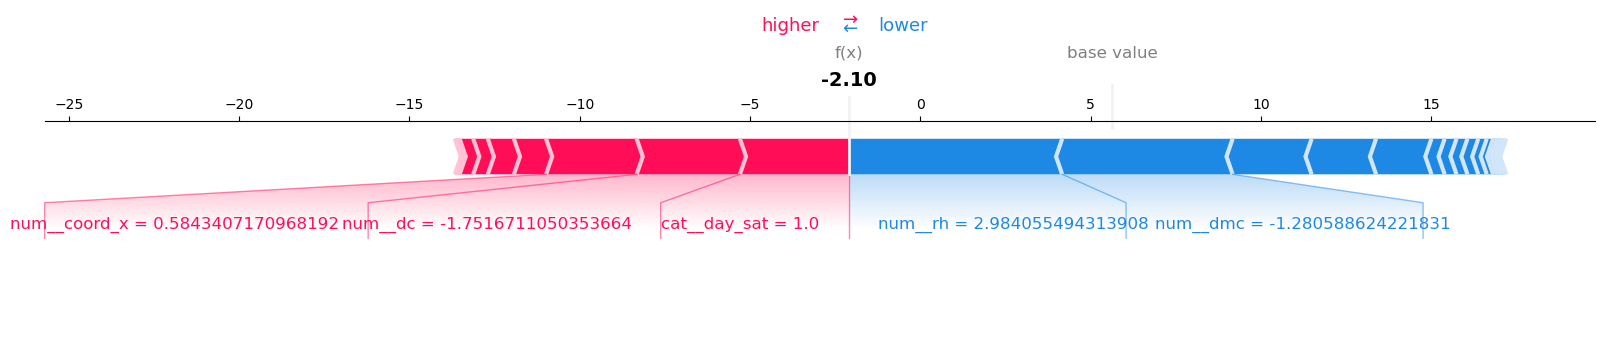

In [84]:
# Step 3: Local Explanation

# Select an observation
observation_index = 0
X_observation = X_test_transformed_df.iloc[observation_index]
y_observation = Y_test.iloc[observation_index]

# Get the SHAP values for this observation
shap_values_observation = shap_values[observation_index]

# Expected value (base value)
expected_value = explainer.expected_value

# Create force plot
shap.force_plot(
    expected_value,
    shap_values_observation,
    X_observation,
    feature_names=feature_names,
    matplotlib=True
)

# SHAP Force Plot Analysis

In this SHAP force plot, we observe how different features contribute to the final prediction by either pushing it up or down relative to a baseline (the model's average prediction).

## Feature Impact

- **Red bars** represent features pushing the prediction higher. In this case:
  - `num__coord_x` has a moderate positive impact, with a value of **0.5843**.
  - `num__dc` has a slightly larger negative value, but since it's in red, it increases the prediction. This could be due to the scale or transformation applied.
  - `cat__day_sat` contributes positively when its value is **1.0**, indicating that it's a Saturday, which in this context might be correlated with higher values.

- **Blue bars** show features pushing the prediction lower:
  - `num__rh` (relative humidity) with a value of **2.9840** has a significant negative impact on the prediction, suggesting that high humidity could be associated with reduced outcomes.
  - `num__dmc` with a value of **-1.2805** also decreases the prediction.

## Magnitude of Influence

The length of each bar reflects the magnitude of each feature's influence on the prediction. Features with longer bars have a greater impact.

- Here, `num__rh` and `num__dc` have the largest individual impacts (in opposite directions), suggesting that these are key factors in determining the final output.

## Prediction Shift

The final prediction (**f(x) = -2.10**) is the result after all feature contributions are applied to the base value.

- This shows that the combined effect of all the blue features (negative contributors) outweighs the red ones, pushing the final value lower than the baseline.

In [92]:
# Identify Most Important Features for This Observation

# Create a DataFrame of SHAP values
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Value': shap_values_observation,
    'Feature Value': X_observation.values
})

# Sort by absolute SHAP value
shap_df['abs_SHAP_Value'] = shap_df['SHAP Value'].abs()
shap_df_sorted = shap_df.sort_values(by='abs_SHAP_Value', ascending=False)

# Display the top features
print("Top features contributing to the prediction:")
print(shap_df_sorted.head())


Top features contributing to the prediction:
         Feature  SHAP Value  Feature Value  abs_SHAP_Value
7        num__rh   -6.263564       2.984055        6.263564
3       num__dmc   -5.003486      -1.280589        5.003486
24  cat__day_sat    3.196592       1.000000        3.196592
4        num__dc    3.031246      -1.751671        3.031246
0   num__coord_x    2.659810       0.584341        2.659810


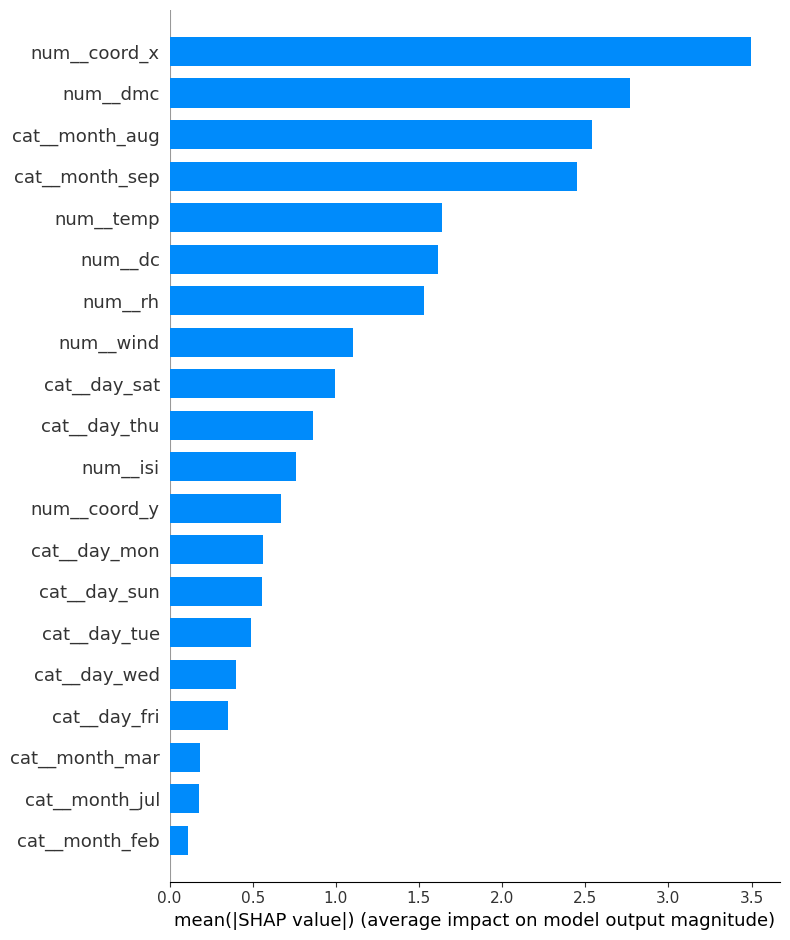

In [93]:
# Global Explanation

# Create summary plot
shap.summary_plot(
    shap_values,
    X_test_transformed_df,
    feature_names=feature_names,
    plot_type='bar'
)

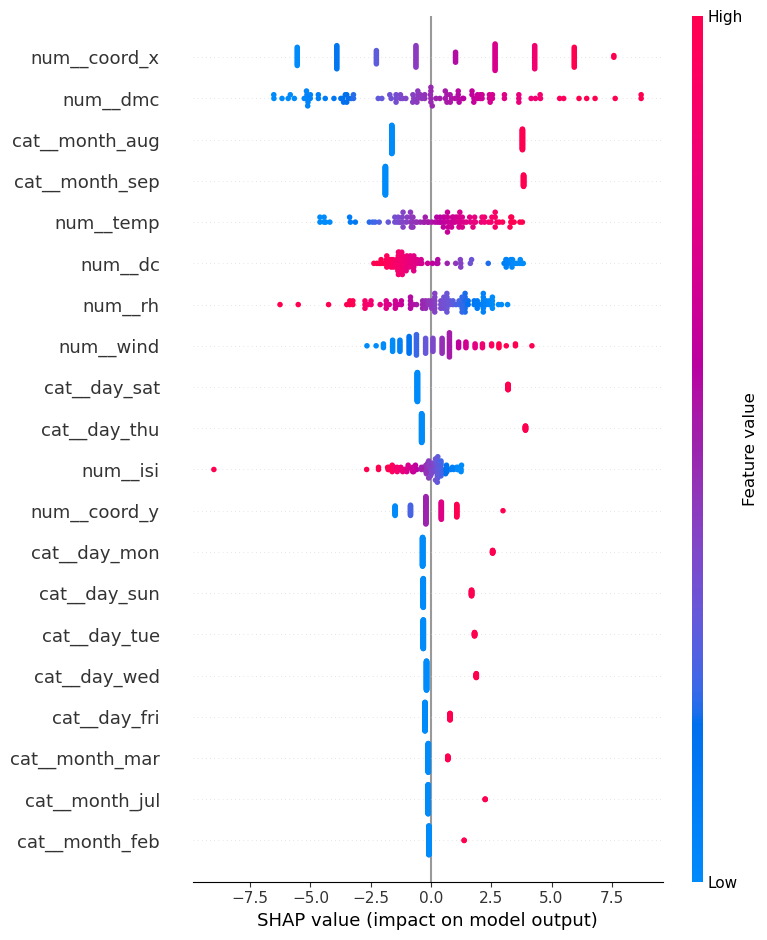

In [90]:
# Detailed summary plot
shap.summary_plot(
    shap_values,
    X_test_transformed_df,
    feature_names=feature_names
)

# SHAP Analysis Overview

## SHAP Summary Bar Plot

- **Top Features:** `num__coord_x` stands out as the most impactful feature, with `num__dmc`, `cat__month_aug`, and `cat__month_sep` also playing significant roles. This suggests that location (`coord_x`) and seasonal patterns (August, September) are crucial for predictions.

- **Feature Impact:** Positive SHAP values push the prediction up, while negative ones pull it down. This provides insight into which features generally increase or decrease the predicted fire area.

## SHAP Beeswarm Plot

- **Color & Value:** Red indicates high values, while blue represents low values. For example, high `num__coord_x` values have a positive impact on predictions.

- **Spread:** Some features, such as `num__temp` and `num__dc`, show wide SHAP value ranges, meaning their impact varies significantly depending on specific values.

## Specific Prediction Breakdown

- **Key Influences:** `num__rh` (relative humidity) and `num__dmc` both have strong negative SHAP values, suggesting that higher humidity and lower DMC index reduce the predicted fire area.

- **Positive Contributors:** `cat__day_sat` (Saturday) has a notable positive SHAP value, indicating that weekends might correlate with conditions leading to larger fire areas.

## Summary

In short, location, season, and specific weather indicators are crucial for predicting fire spread in this model.


> Q: If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

# Feature Reduction Analysis

## Features to Consider Removing

- **Low Impact Features:** Features like `cat__month_mar`, `cat__month_jul`, `cat__month_feb`, and some weekday indicators (e.g., `cat__day_mon`, `cat__day_fri`) consistently show low SHAP values. This suggests they don’t contribute significantly to the model's predictions.

- **Reasoning:** If these features don’t influence predictions meaningfully, removing them could simplify the model without a performance loss. A simplified model aids interpretability and may slightly reduce training time.

## How to Test Their Impact

1. **Create a Reduced Model:** Remove the selected low-impact features and retrain the model with the same preprocessing and pipeline setup.

2. **Cross-Validate:** Use cross-validation to assess the performance of the reduced model. Compare metrics such as RMSE, MAE, or R² with the full model to identify any significant changes.

3. **SHAP Comparison:** Generate SHAP values for the reduced model to ensure that the primary contributing features still drive predictions effectively.

4. **Hypothesis Testing:** Perform statistical tests (e.g., paired t-tests on cross-validation scores) to compare performance metrics. This will determine if the differences are statistically significant.

- **Outcome:** If model performance remains stable—or even improves—it confirms that these features were not enhancing the model and can be removed safely.


## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [x] Created a branch with the correct naming convention.
- [x] Ensured that the repository is public.
- [x] Reviewed the PR description guidelines and adhered to them.
- [x] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.